# Calculate DIC content using CRMs

This NoteBook shows examples of a workflow that determines the DIC and TA content of samples analysed on a VINDTA 3C (at UEA), and assesses the quality of measurements based on results for the Certified Reference Materials (CRMs) run on each analysis day. 

For questions, contact Elise S. Droste (e.droste@uea.ac.uk)

***
# Introduction

In this NoteBook, dissolved inorganic carbon (DIC) is determined from the raw VINDTA data, using the Certified Reference Materials runs from the VINDTA. 

The quality of the CRM runs is assessed and checked, removing or flagging any questionable CRM runs. The DIC content of the samples will be quality checked in the `DICTA_samples_QC_ipynb` NoteBook. 

The total alkalinity (TA) will be processed in a separate script (`TA_CRMs_QC.ipynb`), using the output of the current NoteBook. 

***
# References

Dickson, 2007, ... 


***
# Packages

In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
from dateutil.parser import parse
from IPython.core.interactiveshell import InteractiveShell 
from pathlib import Path

warnings.filterwarnings('ignore') # suppresses warning messages from packages
InteractiveShell.ast_node_interactivity = "all" # allows you to see multiple outputs from a single cell

In [2]:
# To be able to see plotly graphs inside the notebook: 

# Added this on 20230913 when I migrated work to a new (AWI) laptop, because plotly graphs were not showing up. This worked!! 
# https://www.ibm.com/support/pages/plotly-produced-blank-graph-jupyter-lab-ide
# https://plotly.com/python/renderers/
import plotly.io as pio
#pio.renderers.default = 'sphinx_gallery' # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'
pio.renderers.default = 'iframe' # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'


***
# Modules

`calc_DIC` is a module that uses a Class containing functions for the dissolved inorganic carbon data processing. It ensures consistent processing and formatting of the data. Import here. Classes are created after the data has been imported. 

In [3]:
from UEA_VINDTA_pkg.calc_DIC import CalcDIC

Hello! Before running the CalcDIC Class, make sure the filenames of the runs are correct.
Imported crmbatch script.
Imported CalcDIC class.


***
# Import raw VINDTA data

The imported data is raw, but has been checked for filenaming mistakes, sample temperature corrections, and aborted runs (for which there is no data) have been removed in `DICTA_fileprep.ipynb`. 

In [4]:
datadir = Path("../output_data/fileprepped_rawdata/") # file directory
datafile = "testrawdata_LucySummary_prepped_20240725.csv" # filename # for illustration purposes, we're here importing a dataset that has already been prepped

vindta_data = pd.read_csv(Path(datadir) / datafile, na_values = -999) 

***
# Preliminary DIC determination

## Create the class

Create classes with the data to perform calculations. 

In [5]:
vindta = CalcDIC(vindta_data)


All junk samples (Station = 9999) have been removed.
salinity_availability exists as column
ctd_temp_availability exists as column
sampling_date exists as column
Creating sample_temp_flag as a column
Using Cast number for CRMs as crm_batch input.
sampling_date found in the columns of the DataFrame. Make sure it's correctly populated, i.e. not empty.
Set an alternative sample temperature in sample_temperature_alternative column, if relevant!


***
## Add the certified values for CRMs

Note: The module/Class will use the CRM batch in the raw datafile, so make sure this is correct (i.e. in the "Cast" column; see filenaming conventions)! 

Make sure the information of certified content in the CRM batch is given in the "crm_batch_lookup.csv". If not, find it in https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/Dickson_CRM/batches.html and add it into the file)


In [8]:
vindta.add_dickson()


Location of CRM Dickson info: UEA_VINDTA_pkg/crm_batch_lookup.csv. Change if necessary.
Added the CRM information for salinity, phosphate, silicate, and nitrate.


***
## Calculate DIC (preliminary)

DIC is here calculated prior to removing any faulty CRM runs. As CRMs are used to calibrate the measured DIC content, this will affect the DIC content determined for the samples. In this first step, DIC content is calculated for all runs (CRMs and samples), and the results for the CRMs are quality checked. If necessary, bad CRM runs are removed, and the DIC content is re-calculated. 

In [9]:
vindta.calculate_dic()

Using sample temperature as temperature. You can change temperature to use in PICCOLO_calc_DIC.py
There are 17 unique analysis days (i.e. DIC cells) during which samples were run.


***
## First look at the CRMs (QC)

Initial QC is just about the CRMs. The extract_crms() function creates a dataframe that serve as easy input into the functions that visualise the CRM results (e.g. qc_crms()). 

In [10]:
vindta.extract_crms()

Visualise the CRM run results per DIC cell in terms of coulometer counts. 

X axis: analysis time -- Y axis: Net DIC counts (background counts corrected) -- Title: analysis date in yyymmdd -- diff = max-min of lin reg
The following cell numbers have drift > 100 counts during the day: 
4
8
9
10
11
12
13
15
16
17
18
19
21
Figure saved as self.qc_crms_cts_fig


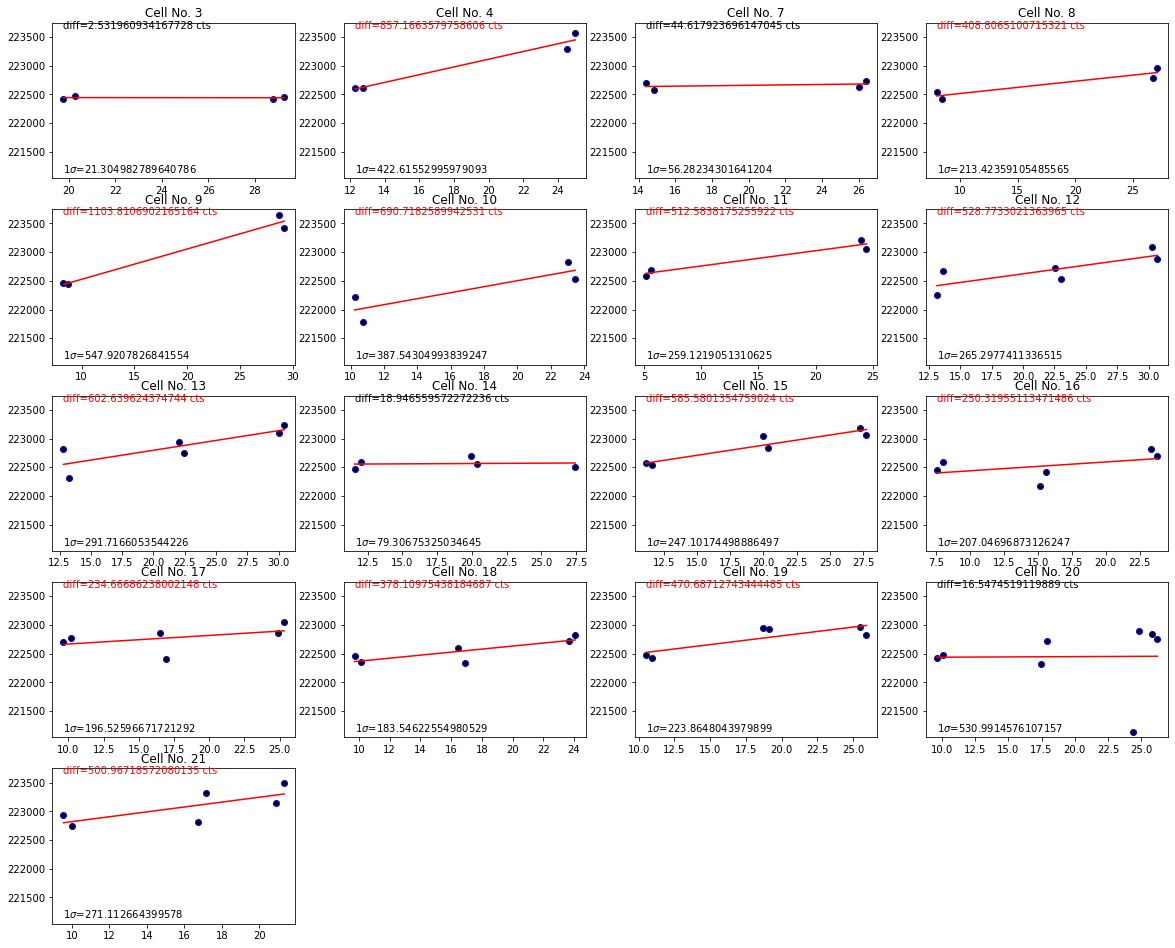

In [11]:
vindta.qc_crms(use = "counts")

Visualise the CRM run results per DIC cell in terms of DIC content. 

X axis: analysis time -- Y axis: Net DIC counts (background counts corrected) -- Title: analysis date in yyymmdd -- diff = max-min of lin reg
The following cell numbers have drift > 3 $\mu$mol kg$^{-1}$ during the day: 
4
8
9
10
11
12
13
15
18
19
21
Figure saved as self.qc_crms_concentration_fig


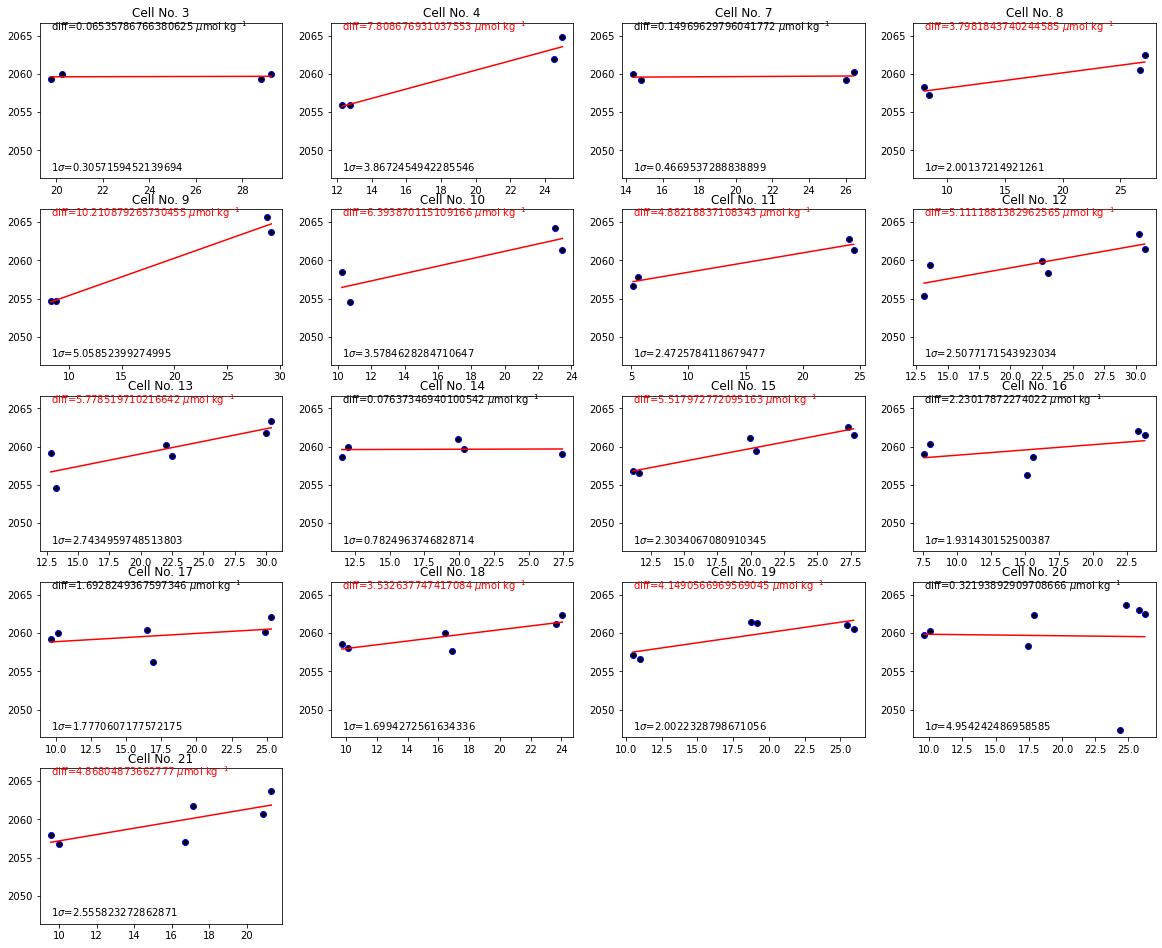

In [12]:
vindta.qc_crms(use = "concentration")

Visualise the CRM DIC content results sequentially to assess overall analytical uncertainty and to further consider faulty runs. 

In [13]:
vindta.dic_x_chart()

Figure saved as self.dic_x_chart_fig


Report on any CRMs that look odd/faulty. Check lab books if something went wrong during analysis and assess their quality. 

Quickly assessing statistics of CRM runs. 

Overall uncertainty of the samples will be determined by the 1 sigma of all CRM runs. 

In [14]:
vindta.crm["dic_sample_umol_per_kg"].describe()

count      89.000000
mean     2059.660000
std         2.802537
min      2047.360844
25%      2058.298051
50%      2059.959395
75%      2061.472880
max      2065.664662
Name: dic_sample_umol_per_kg, dtype: float64

In [15]:
vindta.crm["DIC total counts"].describe()

count        89.000000
mean     222882.168539
std         322.054387
min      222318.000000
25%      222651.000000
50%      222822.000000
75%      223061.000000
max      223962.000000
Name: DIC total counts, dtype: float64

If wanted, save the figures above. 

In [18]:
fig_dir = Path("../output_figures/qc_crms_dic")

# Matplotlib figs
fname_crms_counts = "qc_crms_dic_cts_vindta_firstlook_" + datetime.date.today().strftime(format = "%Y%m%d") + ".png"
fname_crms_concentration = "qc_crms_dic_conc_vindta_firstlook_" + datetime.date.today().strftime(format = "%Y%m%d") + ".png"
# vindta.qc_crms_cts_fig.savefig(fig_dir / fname_crms_counts, frameon=None) # uncomment
# vindta.qc_crms_concentration_fig.savefig(fig_dir / fname_crms_concentration, frameon=None) # uncomment


In [19]:
# Plotly figs

# https://towardsdatascience.com/extending-knime-python-integration-with-plotly-express-and-kaleido-5c306074a5ca 
# Had problems with the kaleido executable but were solved when I uninstalled kaleido and then re-installed it 
# using the plotly channel. See the notes_recoveranaconda_20211011.rtf file. 
fname_xchart = "qc_crms_dic_xchart_vindta_firstlook_" + datetime.date.today().strftime(format = "%Y%m%d") + ".png"
# vindta.dic_x_chart_fig.write_image(str(fig_dir / fname_xchart_laurel)) # uncomment

# If you use .write_image without the str(), then you will get the following error: 
# AttributeError: 'PosixPath' object has no attribute 'write'
# Because for some reason it does not like pahtlib.Path objects... 
# See here: https://github.com/plotly/plotly.py/issues/2753

***
# Secondary DIC determination

## Remove faulty CRM runs

Remove the faulty CRM runs identified in the previous section. 

In [20]:
crm_dic_to_remove = ["8888_208_0156_0_1_1"] # make a list of filenames of CRMs for which the DIC run was faulty. Can add more than 1!
vindta.df["DIC total counts"].where(~vindta.df["Sample Name"].isin(crm_dic_to_remove), np.float("NaN"), inplace = True) # replace those with NAN for "DIC total counts"

In [21]:
vindta.df[vindta.df["DIC total counts"].isna() == True] # check

,Sample Name,Comments,DIC flag,TA flag,Analysis Type,Date (analysis),Time (analysis),Station,Cast,Niskin,...,dic_crm_counts_per_umol_mean_allcells,dic_crm_counts_per_umol_std_allcells,dic_sample_pip_umol_allcells,dic_sample_umol_per_l_allcells,dic_sample_umol_per_kg_allcells,dic_crm_counts_per_umol_mean_percell,dic_crm_counts_per_umol_std_percell,dic_sample_pip_umol,dic_sample_umol_per_l,dic_sample_umol_per_kg
475,8888_208_0156_0_1_1,,NaN,NaN,3,2024-02-17,2338,8888,208,156,...,4843.053583,7.952088,45.661213,2090.312886,2044.838645,4837.087294,12.438317,45.717533,2092.891176,2047.360844


***
## Calculate DIC (secondary)

Now that the faulty CRMs for DIC have been removed, re-calculate DIC. 

In [22]:
vindta.calculate_dic()

Using sample temperature as temperature. You can change temperature to use in PICCOLO_calc_DIC.py
There are 17 unique analysis days (i.e. DIC cells) during which samples were run.


***
## Second look at the CRMs (QC)

In [23]:
vindta.extract_crms()

X axis: analysis time -- Y axis: Net DIC counts (background counts corrected) -- Title: analysis date in yyymmdd -- diff = max-min of lin reg
The following cell numbers have drift > 100 counts during the day: 
4
8
9
10
11
12
13
15
16
17
18
19
20
21
Figure saved as self.qc_crms_cts_fig


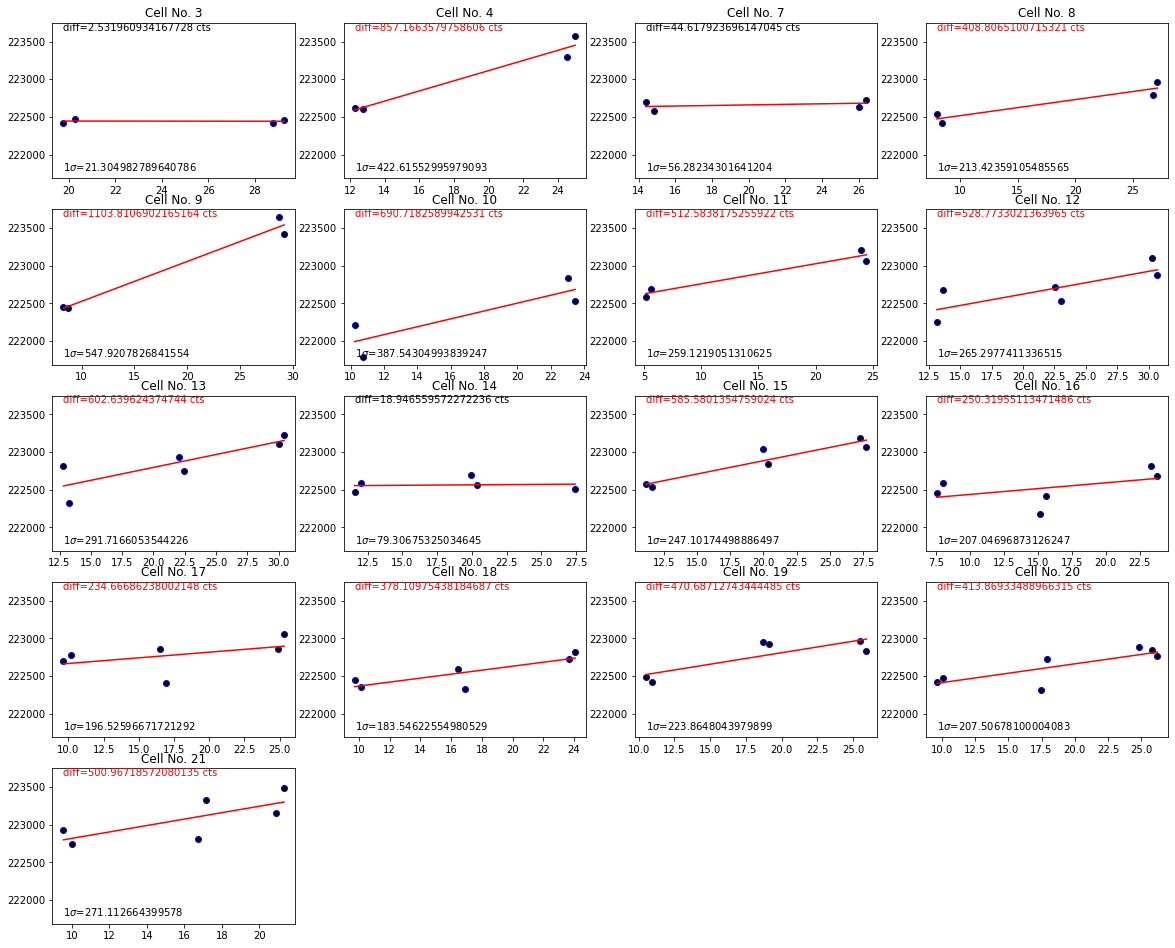

In [24]:
vindta.qc_crms(use = "counts")

X axis: analysis time -- Y axis: Net DIC counts (background counts corrected) -- Title: analysis date in yyymmdd -- diff = max-min of lin reg
The following cell numbers have drift > 3 $\mu$mol kg$^{-1}$ during the day: 
4
8
9
10
11
12
13
15
18
19
20
21
Figure saved as self.qc_crms_concentration_fig


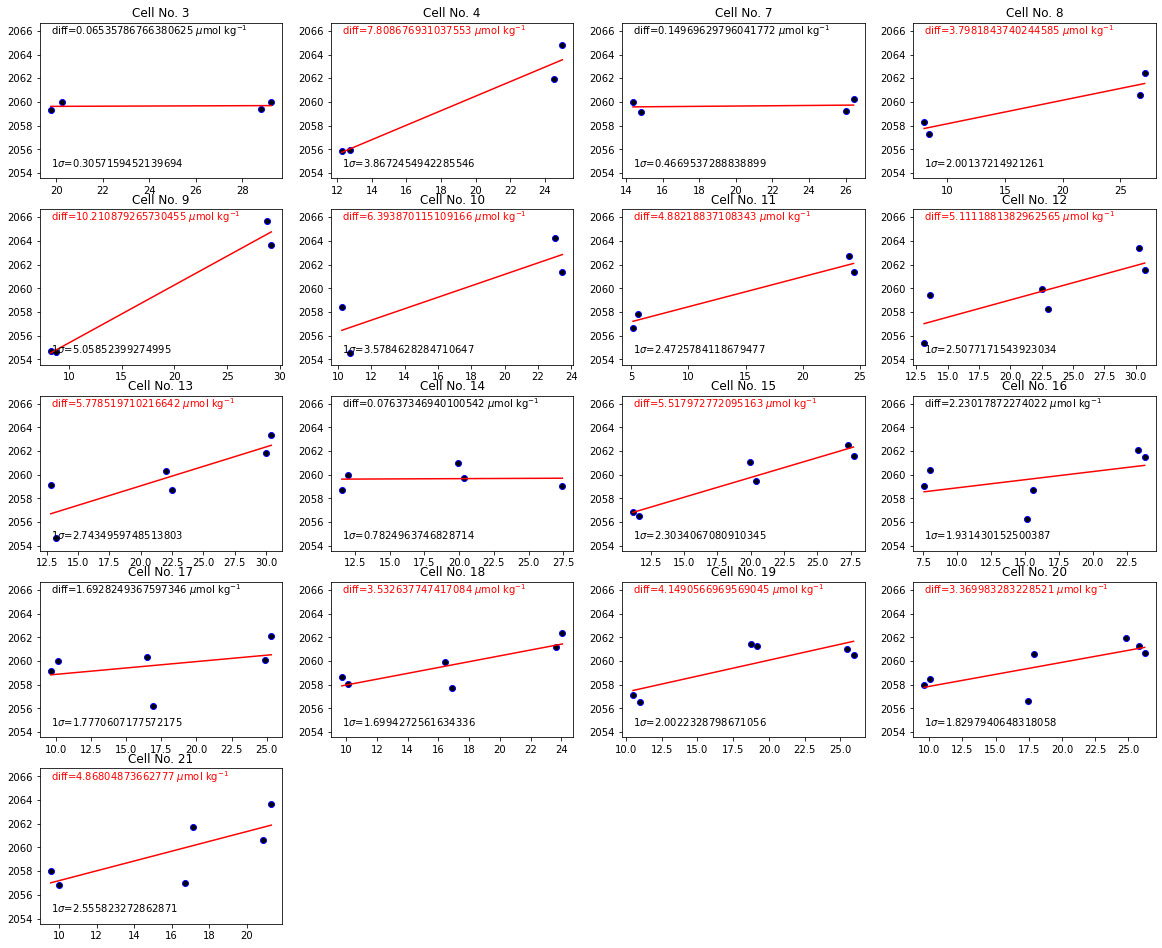

In [25]:
vindta.qc_crms(use = "concentration")

In [26]:
vindta.dic_x_chart()

Figure saved as self.dic_x_chart_fig


In [27]:
vindta.crm["dic_sample_umol_per_kg"].describe()

count      88.000000
mean     2059.660000
std         2.440680
min      2054.558453
25%      2058.071284
50%      2059.953497
75%      2061.367898
max      2065.664662
Name: dic_sample_umol_per_kg, dtype: float64

In [28]:
vindta.crm["DIC total counts"].describe()

count        88.000000
mean     222882.488636
std         323.885747
min      222318.000000
25%      222650.250000
50%      222821.000000
75%      223070.500000
max      223962.000000
Name: DIC total counts, dtype: float64

#### Save figures

Save figures, if required (see above)

***
# Tertiary DIC determination

Repeat the process as from above if required! 

## Remove faulty CRM runs (cont'd)

No more CRM runs were deemed faulty. 

## Calculate DIC (tertiary)

## Tertiary look at CRMs (QC)

***
# Drift corrections

Assess whetehr drift occurred. This may have happend throughout the analysis period as a whole, and/or during a particular analysis day on a single DIC cell. 

We can apply a drift correction for each DIC cell separately (note: we assume linear drift throughout the day, but usually do not have enough CRM runs do validate this) and compare those values to the uncorrected values. If significantly different, the drift corrected values will be used. 

Based on the figures for the QC above, determine which DIC cells might benefit from a drift correction. 

A drift corrected value will only be determined for given cells. 

The impact of the drift correction on the sample values is assessed in `DICTA_samples_QC.ipynb`. 

First drift correction
DIC content has been re-calculated according to drift corrected CRM values.


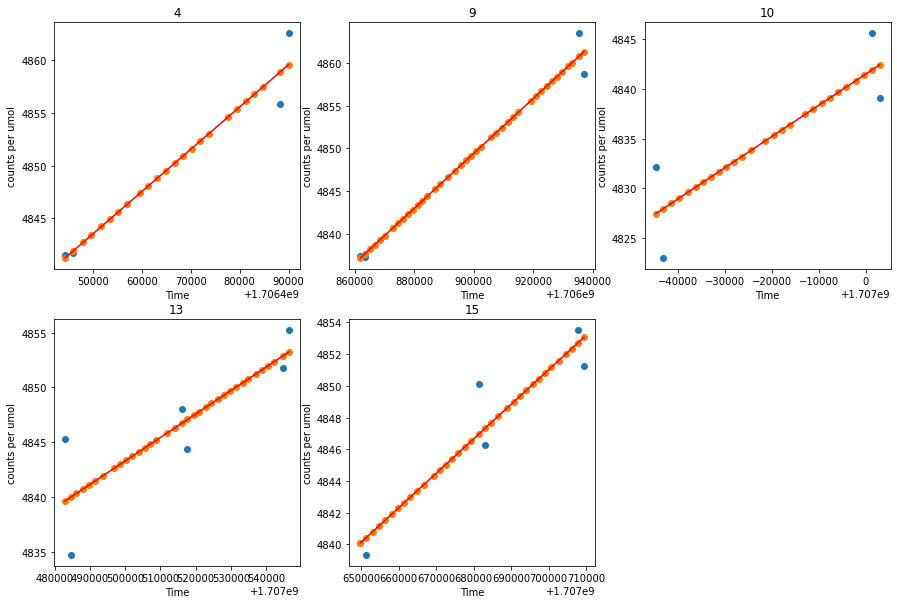

In [29]:
vindta.calculate_dic_driftcorr(tobe_driftcorr_cell_list = [4, 9, 10, 13, 15], time_frame = "single_cells")


***
# Compare percell to allcells

## CRMs

In [30]:
vindta.crm["dic_sample_umol_per_kg"].describe()

vindta.crm["dic_sample_umol_per_kg_allcells"].describe()


count      88.000000
mean     2059.660000
std         2.440680
min      2054.558453
25%      2058.071284
50%      2059.953497
75%      2061.367898
max      2065.664662
Name: dic_sample_umol_per_kg, dtype: float64

count      88.000000
mean     2059.660000
std         3.024042
min      2050.942758
25%      2057.551004
50%      2059.474416
75%      2061.004992
max      2068.140514
Name: dic_sample_umol_per_kg_allcells, dtype: float64

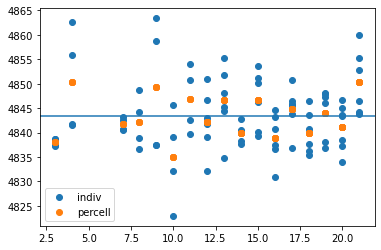

In [31]:

plt.scatter(vindta.crm["DIC cell Number (sequential)"], vindta.crm["dic_crm_counts_per_umol"], label = "indiv")
plt.scatter(vindta.crm["DIC cell Number (sequential)"], vindta.crm["dic_crm_counts_per_umol_mean_percell"], label = "percell")
plt.axhline(vindta.crm["dic_crm_counts_per_umol_mean_allcells"].unique())

plt.legend();



***
## Samples

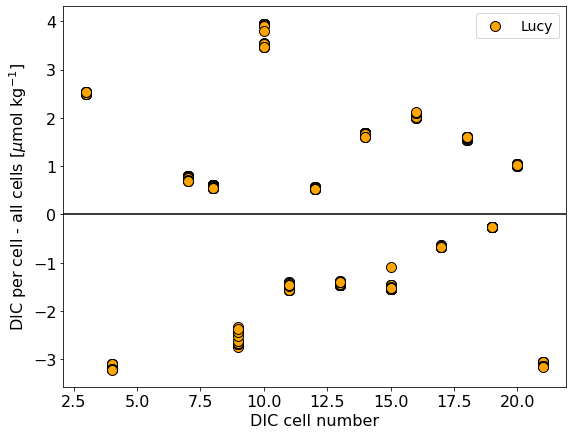

In [34]:
fig = plt.figure(figsize = (9, 7))
ax0 = fig.add_subplot(111)

# Exclude the CRMs to only look at sample results
cond1 = vindta.df["Station"] != 8888

ax0.scatter(vindta.df["DIC cell Number (sequential)"].loc[cond1], vindta.df["dic_sample_umol_per_kg"].loc[cond1] - vindta.df["dic_sample_umol_per_kg_allcells"].loc[cond1], 
            c = "orange", s = 100, edgecolor = "k", label = "Lucy")

ax0.axhline(y = 0, c = "k", zorder = 0)


ax0.tick_params(axis = "both", labelsize = 16)
ax0.set_ylabel("DIC per cell - all cells [$\mu$mol kg$^{-1}$]", fontsize = 16)
ax0.set_xlabel("DIC cell number", fontsize = 16);

ax0.legend(fontsize = 14); 

***
# Flag CRMs 

<font color=orange> Assess if any furtherCRMs need to be flagger. </font>

***
# Assess drift corrections

<font color=orange> Decide on final DIC values (change in column_names accordingly)

***
# Save the preliminary DIC values

In [39]:
%%bash

cd ../output_data/

ls

pwd

DICTA_calculated
DIC_calculated
fileprepped_rawdata
/Users/eldros001/ED_Science/VINDTA_DATA_PROCESSING/output_data


In [40]:
prelim_datadir = Path("../output_data/DIC_calculated/")
prelim_datafile = "dic_prelim_" + datetime.date.today().strftime(format = "%Y%m%d") + ".csv"

vindta.df.to_csv(prelim_datadir / prelim_datafile, index = False)

:)